In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import csv
import os
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
os.getcwd()

'/Users/skyler/chi18_ds8/student_submissions/projects/project_3/skyler_lehto'

In [3]:
# Change directory to folder I downloaded with NHTSA data from Kaggle.
# Data is from here: https://www.kaggle.com/nhtsa/2015-traffic-fatalities
os.chdir('/Users/skyler/Downloads/2015-traffic-fatalities')

In [4]:
csv_list=os.listdir()

In [5]:
# Remove unnecessary folders.
csv_list.remove('docs')
csv_list.remove('extra')

In [6]:
csv_list.sort()

In [7]:
csv_list

['.DS_Store',
 'accident.csv',
 'cevent.csv',
 'damage.csv',
 'distract.csv',
 'drimpair.csv',
 'factor.csv',
 'maneuver.csv',
 'miper.csv',
 'nmimpair.csv',
 'nmprior.csv',
 'parkwork.csv',
 'pbtype.csv',
 'person.csv',
 'pkl_lr_lim_model.p',
 'pkl_lr_model.p',
 'vehicle.csv',
 'vevent.csv',
 'vindecode.csv',
 'vision.csv']

In [12]:
# Put csv files into data frames.
accident=pd.DataFrame.from_csv('accident.csv')
cevent=pd.DataFrame.from_csv('cevent.csv')
damage=pd.DataFrame.from_csv('damage.csv')
distract=pd.DataFrame.from_csv('distract.csv')
drimpair=pd.DataFrame.from_csv('drimpair.csv')
factor=pd.DataFrame.from_csv('factor.csv')
maneuver=pd.DataFrame.from_csv('maneuver.csv')
miper=pd.DataFrame.from_csv('miper.csv')
nmimpair=pd.DataFrame.from_csv('nmimpair.csv')
nmprior=pd.DataFrame.from_csv('nmprior.csv')
parkwork=pd.DataFrame.from_csv('parkwork.csv')
pbtype=pd.DataFrame.from_csv('pbtype.csv')
person=pd.DataFrame.from_csv('person.csv')
#vehicle=pd.DataFrame.from_csv('vehicle.csv') # unresolved error with this file, so omitting it
vevent=pd.DataFrame.from_csv('vevent.csv')
vindecode=pd.DataFrame.from_csv('vindecode.csv')
vision=pd.DataFrame.from_csv('vision.csv')

In [13]:
accident['STATE']=accident.index # Create new state column (this file has it in the index).

In [14]:
# Select only some of the columns from accident file.
accident=pd.DataFrame(accident,columns=['ST_CASE','VE_TOTAL','VE_FORMS','PVH_INVL','PERNOTMVIT','PERMVIT','PERSONS',
                                        'STATE','DAY','MONTH','DAY_WEEK','HOUR','MINUTE','NHS','RUR_URB',
                                        'FUNC_SYS','RD_OWNER','ROUTE','SCH_BUS','FATALS','DRUNK_DR'])


In [15]:
# Convert non-binary categorical variables into dummy variables.
accident=pd.get_dummies(accident,columns=['DAY','MONTH','DAY_WEEK','HOUR','MINUTE','NHS',
                                          'RUR_URB','FUNC_SYS','RD_OWNER','ROUTE','STATE'])
damage=pd.get_dummies(damage,columns=['MDAREAS'])
distract=pd.get_dummies(distract,columns=['MDRDSTRD'])
drimpair=pd.get_dummies(drimpair,columns=['DRIMPAIR'])
factor=pd.get_dummies(factor,columns=['MFACTOR'])
maneuver=pd.get_dummies(maneuver,columns=['MDRMANAV'])

In [16]:
# Collapse data into one row per accident. For columns where the same accident has different values in its 
# multiple rows, the relevant statistic is always the maximum of these values.
damage=damage.groupby(['ST_CASE']).max()
distract=distract.groupby(['ST_CASE']).max()
drimpair=drimpair.groupby(['ST_CASE']).max()
factor=factor.groupby(['ST_CASE']).max()
maneuver=maneuver.groupby(['ST_CASE']).max()

In [17]:
df_list_full=[accident,
 cevent,
 damage,
 distract,
 drimpair,
 factor,
 maneuver,
 miper,
 nmimpair,
 nmprior,
 parkwork,
 pbtype,
 person,
 vevent,
 vindecode,
 vision]
df_list_short=[accident,
 distract,
 drimpair,
 factor,
 maneuver,
 miper,
 nmimpair,
 nmprior,
 parkwork,
 pbtype,
 vision]
df_list=[accident,damage,distract,drimpair,factor,maneuver] # In the end, these were the only six data frames I saw
# fit to include.

In [18]:
# Merge data frames into one master data frame.
master=pd.DataFrame(columns=['ST_CASE'])
for df in df_list:
    master=master.merge(df,how='outer',on=['ST_CASE'])

In [19]:
# Remove variables with high or perfect multicollinearity, 
# and DRIMPAIR_9 (which has inebriation--gives away what we are trying to predict),
# and DRIMPAIR_0 (it would necessarily be no impairment if it wasn't drunk driving).
columns = ['VEH_NO','VEH_NO_x','VEH_NO_y','VE_FORMS','PERSONS','DRIMPAIR_9','DRIMPAIR_0']
master.drop(columns, inplace=True, axis=1)

In [20]:
# Take a look at columns that have been included.
col_list=list(master.columns)
col_list.sort()
for e in col_list:
    print (e)

DAY_1
DAY_10
DAY_11
DAY_12
DAY_13
DAY_14
DAY_15
DAY_16
DAY_17
DAY_18
DAY_19
DAY_2
DAY_20
DAY_21
DAY_22
DAY_23
DAY_24
DAY_25
DAY_26
DAY_27
DAY_28
DAY_29
DAY_3
DAY_30
DAY_31
DAY_4
DAY_5
DAY_6
DAY_7
DAY_8
DAY_9
DAY_WEEK_1
DAY_WEEK_2
DAY_WEEK_3
DAY_WEEK_4
DAY_WEEK_5
DAY_WEEK_6
DAY_WEEK_7
DRIMPAIR_1
DRIMPAIR_10
DRIMPAIR_2
DRIMPAIR_3
DRIMPAIR_4
DRIMPAIR_5
DRIMPAIR_8
DRIMPAIR_95
DRIMPAIR_96
DRIMPAIR_98
DRIMPAIR_99
DRUNK_DR
FATALS
FUNC_SYS_1
FUNC_SYS_2
FUNC_SYS_3
FUNC_SYS_4
FUNC_SYS_5
FUNC_SYS_6
FUNC_SYS_7
FUNC_SYS_96
FUNC_SYS_98
FUNC_SYS_99
HOUR_0
HOUR_1
HOUR_10
HOUR_11
HOUR_12
HOUR_13
HOUR_14
HOUR_15
HOUR_16
HOUR_17
HOUR_18
HOUR_19
HOUR_2
HOUR_20
HOUR_21
HOUR_22
HOUR_23
HOUR_3
HOUR_4
HOUR_5
HOUR_6
HOUR_7
HOUR_8
HOUR_9
HOUR_99
MDAREAS_1
MDAREAS_10
MDAREAS_11
MDAREAS_12
MDAREAS_13
MDAREAS_14
MDAREAS_15
MDAREAS_2
MDAREAS_3
MDAREAS_4
MDAREAS_5
MDAREAS_6
MDAREAS_7
MDAREAS_8
MDAREAS_9
MDAREAS_99
MDRDSTRD_0
MDRDSTRD_1
MDRDSTRD_10
MDRDSTRD_12
MDRDSTRD_13
MDRDSTRD_14
MDRDSTRD_15
MDRDSTRD_16
MDRDSTRD_

In [21]:
# Drop dummies for other/missing categories.
columns=['DRIMPAIR_95', 'DRIMPAIR_96', 'DRIMPAIR_98', 'DRIMPAIR_99', 'FUNC_SYS_96', 'FUNC_SYS_98', 'FUNC_SYS_99', 
 'HOUR_99', 'MDAREAS_99', 'MDRDSTRD_92', 'MDRDSTRD_93', 'MDRDSTRD_96', 'MDRDSTRD_97', 'MDRDSTRD_98', 'MDRDSTRD_99', 
 'MDRMANAV_92', 'MDRMANAV_95', 'MDRMANAV_98', 'MDRMANAV_99', 'MFACTOR_97', 'MFACTOR_98', 'MFACTOR_99', 'MINUTE_99', 
 'NHS_9', 'RD_OWNER_96', 'RD_OWNER_98', 'RD_OWNER_99', 'ROUTE_8', 'ROUTE_9', 'RUR_URB_6', 'RUR_URB_8', 'RUR_URB_9']
master.drop(columns, inplace=True, axis=1)

In [22]:
master

,ST_CASE,VE_TOTAL,PVH_INVL,PERNOTMVIT,PERMVIT,SCH_BUS,FATALS,DRUNK_DR,DAY_1,DAY_2,...,MFACTOR_14,MFACTOR_15,MFACTOR_16,MFACTOR_17,MDRMANAV_0,MDRMANAV_1,MDRMANAV_2,MDRMANAV_3,MDRMANAV_4,MDRMANAV_5
0,10001,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,10002,1,0,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,10003,1,0,0,2,0,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
3,10004,1,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,10005,2,0,0,2,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,10006,1,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10007,1,0,0,2,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,10008,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,10009,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10010,2,0,0,2,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [23]:
master.corr() # Create correlation matrix.

,ST_CASE,VE_TOTAL,PVH_INVL,PERNOTMVIT,PERMVIT,SCH_BUS,FATALS,DRUNK_DR,DAY_1,DAY_2,...,MFACTOR_14,MFACTOR_15,MFACTOR_16,MFACTOR_17,MDRMANAV_0,MDRMANAV_1,MDRMANAV_2,MDRMANAV_3,MDRMANAV_4,MDRMANAV_5
ST_CASE,1.000000,-0.000422,-0.007509,-0.052086,0.004705,0.000613,0.009826,0.025936,-0.004129,0.001595,...,-0.002365,0.002821,-0.008637,0.014756,-0.033466,-0.005334,0.009529,0.017206,-0.025110,-0.033109
VE_TOTAL,-0.000422,1.000000,0.284823,-0.130414,0.632705,0.035390,0.105139,-0.052197,-0.005251,0.003549,...,-0.004839,0.002399,-0.000862,0.009437,0.093080,0.030883,0.029385,-0.024049,0.283619,-0.068859
PVH_INVL,-0.007509,0.284823,1.000000,0.161593,-0.012901,0.004625,0.006054,0.025058,-0.002732,0.001047,...,-0.002560,0.003496,-0.001810,-0.004246,-0.008165,0.004787,0.001592,-0.007762,-0.015409,-0.016706
PERNOTMVIT,-0.052086,-0.130414,0.161593,1.000000,-0.171977,-0.006109,-0.035772,-0.181855,-0.000362,-0.002900,...,0.000999,0.013683,0.002948,0.001179,-0.043908,-0.003103,-0.010714,-0.023719,-0.112343,0.241642
PERMVIT,0.004705,0.632705,-0.012901,-0.171977,1.000000,0.086982,0.278214,-0.040210,0.002601,-0.000288,...,0.002174,0.004663,0.010923,0.003357,0.069390,0.027989,0.014935,-0.001091,0.202696,-0.056487
SCH_BUS,0.000613,0.035390,0.004625,-0.006109,0.086982,1.000000,-0.000953,-0.023232,0.004640,-0.001253,...,-0.001111,-0.001111,-0.000785,-0.001843,0.017864,-0.002925,-0.001398,-0.003368,0.032055,-0.001243
FATALS,0.009826,0.105139,0.006054,-0.035772,0.278214,-0.000953,1.000000,0.045530,0.006218,-0.007738,...,0.008399,-0.004804,0.002827,0.002650,-0.002670,-0.004272,-0.002548,-0.005832,0.040754,-0.034440
DRUNK_DR,0.025936,-0.052197,0.025058,-0.181855,-0.040210,-0.023232,0.045530,1.000000,0.016146,-0.007849,...,0.005517,-0.008260,-0.008275,-0.000717,-0.003466,-0.005906,0.004433,-0.003590,-0.051133,-0.077367
DAY_1,-0.004129,-0.005251,-0.002732,-0.000362,0.002601,0.004640,0.006218,0.016146,1.000000,-0.033560,...,0.005481,-0.003557,-0.002515,0.005003,-0.006276,-0.002485,-0.004477,0.004162,-0.006014,-0.002680
DAY_2,0.001595,0.003549,0.001047,-0.002900,-0.000288,-0.001253,-0.007738,-0.007849,-0.033560,1.000000,...,-0.003521,-0.003521,-0.002489,0.005171,0.000085,-0.005795,0.002824,-0.004637,0.003005,-0.003351


In [24]:
# Create sorted list of absolute values of correlation coefficients.
c = master.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

In [25]:
# Print out strongest correlations to check for any additional multicollinearity issues.
print (so[-439:-339])

MDAREAS_7   MDAREAS_1     0.492847
MDAREAS_1   MDAREAS_7     0.492847
MDAREAS_5   MDAREAS_11    0.495337
MDAREAS_11  MDAREAS_5     0.495337
MDAREAS_13  MDAREAS_11    0.496203
MDAREAS_11  MDAREAS_13    0.496203
NHS_1       ROUTE_1       0.496284
ROUTE_1     NHS_1         0.496284
MDAREAS_3   MDAREAS_6     0.498258
MDAREAS_6   MDAREAS_3     0.498258
MDAREAS_1   MDAREAS_13    0.500381
MDAREAS_13  MDAREAS_1     0.500381
            MDAREAS_3     0.500786
MDAREAS_3   MDAREAS_13    0.500786
MDAREAS_10  MDAREAS_6     0.500797
MDAREAS_6   MDAREAS_10    0.500797
NHS_1       FUNC_SYS_1    0.501563
FUNC_SYS_1  NHS_1         0.501563
MDAREAS_5   MDAREAS_9     0.507133
MDAREAS_9   MDAREAS_5     0.507133
            MDAREAS_4     0.511128
MDAREAS_4   MDAREAS_9     0.511128
MDAREAS_1   MDAREAS_10    0.511905
MDAREAS_10  MDAREAS_1     0.511905
MDAREAS_6   MDAREAS_2     0.513259
MDAREAS_2   MDAREAS_6     0.513259
MDAREAS_9   MDAREAS_14    0.513917
MDAREAS_14  MDAREAS_9     0.513917
MDAREAS_2   MDAREAS_

In [26]:
master.corr()['DRUNK_DR'].sort_values() # Examine feature correlations with target variable.

PERNOTMVIT   -0.181855
MDRMANAV_5   -0.077367
HOUR_12      -0.076442
HOUR_10      -0.076167
MDRDSTRD_0   -0.074722
HOUR_9       -0.072544
HOUR_14      -0.072068
NHS_1        -0.071858
HOUR_13      -0.071216
HOUR_8       -0.070581
HOUR_11      -0.069867
DAY_WEEK_2   -0.069848
DAY_WEEK_3   -0.065171
HOUR_15      -0.062866
DAY_WEEK_4   -0.061051
DRIMPAIR_1   -0.060255
FUNC_SYS_3   -0.058279
MDAREAS_15   -0.057549
HOUR_7       -0.056797
VE_TOTAL     -0.052197
MDRMANAV_4   -0.051133
HOUR_6       -0.048931
ROUTE_2      -0.046793
DAY_WEEK_5   -0.045214
RD_OWNER_1   -0.043181
HOUR_16      -0.042194
DRIMPAIR_2   -0.040668
PERMVIT      -0.040210
MDRDSTRD_1   -0.037451
ROUTE_1      -0.037140
                ...   
HOUR_21       0.039012
HOUR_4        0.044849
FATALS        0.045530
FUNC_SYS_6    0.049071
HOUR_22       0.055940
MDAREAS_1     0.060631
RD_OWNER_2    0.065560
MDAREAS_11    0.067144
MDAREAS_6     0.071385
FUNC_SYS_7    0.072347
MDAREAS_9     0.072407
ROUTE_4       0.072984
MDAREAS_2  

Text(0,0.5,'# of Observations')

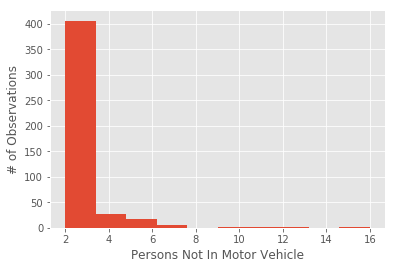

In [27]:
# MVP
master_filtered=master.loc[(master.PERNOTMVIT>1)]
x_hist=master_filtered.PERNOTMVIT
plt.hist(x_hist)
plt.xlabel("Persons Not In Motor Vehicle")
plt.ylabel("# of Observations")

In [28]:
master=master[master.DRUNK_DR<=1] # Exclude a few data points with values of 2 in the target (should be 0 or 1).

In [70]:
y=master['DRUNK_DR']
X=master.drop(['DRUNK_DR','ST_CASE'],axis=1)

In [30]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=44)

In [31]:
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

In [32]:
# Run all the models with default hyperparameters, and apply further tuning to the ones that seem best.

In [33]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
nb.score(X_val_scaled, y_val)

0.7254502740798747

In [34]:
nb = BernoulliNB()
nb.fit(X_train,y_train)
nb.score(X_val,y_val)

0.6947533281127642

In [35]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
lr.score(X_val_scaled, y_val)

0.784494909945184

In [36]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_val_scaled, y_val)

0.7047768206734534

In [37]:
svc = LinearSVC()
svc.fit(X_train_scaled, y_train)
svc.score(X_val_scaled, y_val)

0.7802662490211433

In [38]:
svc = SVC()
svc.fit(X_train_scaled, y_train)
svc.score(X_val_scaled, y_val)

0.7796397807361002

In [39]:
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
dt.score(X_val_scaled, y_val)

0.7122944400939702

In [40]:
bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_jobs=-1)
bc.fit(X_train_scaled, y_train)
bc.score(X_val_scaled, y_val)

0.7644479248238057

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
rf.score(X_val_scaled, y_val)

0.7530148786217697

In [62]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number b/c we're using early stopping
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=50, # stop when validation error hasn't improved in this many rounds
                    verbose=True #gives output log as below
                   )

[0]	validation_0-rmse:0.488083	validation_1-rmse:0.487916
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.477701	validation_1-rmse:0.477382
[2]	validation_0-rmse:0.467303	validation_1-rmse:0.466871
[3]	validation_0-rmse:0.458136	validation_1-rmse:0.4577
[4]	validation_0-rmse:0.450535	validation_1-rmse:0.450218
[5]	validation_0-rmse:0.444209	validation_1-rmse:0.443775
[6]	validation_0-rmse:0.438955	validation_1-rmse:0.4386
[7]	validation_0-rmse:0.434593	validation_1-rmse:0.434183
[8]	validation_0-rmse:0.430915	validation_1-rmse:0.430403
[9]	validation_0-rmse:0.427793	validation_1-rmse:0.427242
[10]	validation_0-rmse:0.424789	validation_1-rmse:0.424272
[11]	validation_0-rmse:0.422385	validation_1-rmse:0.421786
[12]	validation_0-rmse:0.420367	validation_1-rmse:0.419842
[13]	validation_0-rmse:0.418526	validation_1-rmse:0.418034
[14]	validation_0-rmse:0.4167

[137]	validation_0-rmse:0.381765	validation_1-rmse:0.387739
[138]	validation_0-rmse:0.381696	validation_1-rmse:0.387692
[139]	validation_0-rmse:0.38161	validation_1-rmse:0.387651
[140]	validation_0-rmse:0.381535	validation_1-rmse:0.387609
[141]	validation_0-rmse:0.381462	validation_1-rmse:0.387588
[142]	validation_0-rmse:0.38138	validation_1-rmse:0.387608
[143]	validation_0-rmse:0.381272	validation_1-rmse:0.387592
[144]	validation_0-rmse:0.381162	validation_1-rmse:0.387539
[145]	validation_0-rmse:0.381096	validation_1-rmse:0.387513
[146]	validation_0-rmse:0.380993	validation_1-rmse:0.387445
[147]	validation_0-rmse:0.380902	validation_1-rmse:0.387392
[148]	validation_0-rmse:0.38083	validation_1-rmse:0.387358
[149]	validation_0-rmse:0.380783	validation_1-rmse:0.387306
[150]	validation_0-rmse:0.380709	validation_1-rmse:0.387285
[151]	validation_0-rmse:0.380633	validation_1-rmse:0.387246
[152]	validation_0-rmse:0.380553	validation_1-rmse:0.387165
[153]	validation_0-rmse:0.380468	validation

[275]	validation_0-rmse:0.372985	validation_1-rmse:0.385005
[276]	validation_0-rmse:0.372945	validation_1-rmse:0.384998
[277]	validation_0-rmse:0.372888	validation_1-rmse:0.384995
[278]	validation_0-rmse:0.372811	validation_1-rmse:0.384975
[279]	validation_0-rmse:0.372755	validation_1-rmse:0.384944
[280]	validation_0-rmse:0.372682	validation_1-rmse:0.384915
[281]	validation_0-rmse:0.372641	validation_1-rmse:0.384915
[282]	validation_0-rmse:0.372608	validation_1-rmse:0.38491
[283]	validation_0-rmse:0.372563	validation_1-rmse:0.384911
[284]	validation_0-rmse:0.372535	validation_1-rmse:0.3849
[285]	validation_0-rmse:0.372474	validation_1-rmse:0.384895
[286]	validation_0-rmse:0.372426	validation_1-rmse:0.384914
[287]	validation_0-rmse:0.372391	validation_1-rmse:0.384922
[288]	validation_0-rmse:0.372348	validation_1-rmse:0.384914
[289]	validation_0-rmse:0.372314	validation_1-rmse:0.384918
[290]	validation_0-rmse:0.372278	validation_1-rmse:0.384887
[291]	validation_0-rmse:0.372218	validation

[412]	validation_0-rmse:0.367291	validation_1-rmse:0.38498
[413]	validation_0-rmse:0.367262	validation_1-rmse:0.384974
[414]	validation_0-rmse:0.367219	validation_1-rmse:0.384977
[415]	validation_0-rmse:0.367199	validation_1-rmse:0.384973
Stopping. Best iteration:
[365]	validation_0-rmse:0.369071	validation_1-rmse:0.384657



In [64]:
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

lr = LogisticRegression()
lr.fit(X_train, y_train)
rmse(lr.predict(X_val), y_val)

0.45694995146663864

In [ ]:
# (I think gradient boosting did better, but I must have overlooked this at the time.)
# Logistic regression and linear SVC have scored the best, so let's tune those further.

In [45]:
param_grid = {'C': np.linspace(1e-8,0.45,19)}
grid = GridSearchCV(LinearSVC(), param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train_scaled,y_train)
grid.cv_results_

{'mean_fit_time': array([ 0.5389915 , 35.64730482, 35.60847697, 35.40371337, 37.60693388,
        36.71729918, 34.0056684 , 34.2583467 , 34.38705835, 34.32427812,
        34.42161112, 34.58394089, 34.5234488 , 34.61674037, 34.66024203,
        34.78782892, 35.25753083, 36.97645788, 28.66581955]),
 'std_fit_time': array([0.11821798, 0.22418265, 0.57395697, 0.20803947, 0.64169682,
        1.41166611, 0.10742412, 0.17485224, 0.16485035, 0.10942754,
        0.15068036, 0.23435046, 0.24775556, 0.24280066, 0.16407302,
        0.2594577 , 0.20444735, 0.19419841, 9.45690305]),
 'mean_score_time': array([0.02024293, 0.01259675, 0.00451941, 0.00688834, 0.00704994,
        0.00383472, 0.0038754 , 0.00558963, 0.00510211, 0.00347786,
        0.00330591, 0.00370574, 0.00704527, 0.00516357, 0.00477738,
        0.00566931, 0.00551381, 0.00347261, 0.00232029]),
 'std_score_time': array([0.01377529, 0.00721962, 0.00046227, 0.00560006, 0.00743104,
        0.00084472, 0.00036162, 0.00478526, 0.00328292, 0

In [ ]:
# For linear SVC, let's use C=0.15

In [49]:
param_grid = {'C': np.linspace(0.1,0.5,17)}
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train_scaled,y_train)
grid.cv_results_

{'mean_fit_time': array([5.6523046 , 6.66362495, 7.27364826, 7.58771191, 7.73623595,
        7.76328478, 7.97751508, 8.08226123, 8.2090538 , 8.31191688,
        8.31258059, 8.35013199, 8.39130902, 8.48608665, 8.58134828,
        8.62171302, 6.46606898]),
 'std_fit_time': array([0.61184742, 0.50191167, 0.37157117, 0.48755054, 0.54581483,
        0.52165165, 0.55253974, 0.506528  , 0.53761662, 0.70955132,
        0.5713469 , 0.5787069 , 0.5574804 , 0.64105001, 0.61096849,
        0.59831755, 0.69654729]),
 'mean_score_time': array([0.01561742, 0.01090422, 0.00505691, 0.00508256, 0.00878272,
        0.0046968 , 0.00591483, 0.00710244, 0.00527987, 0.00646796,
        0.00507402, 0.00582309, 0.00558872, 0.00530772, 0.00505757,
        0.00510011, 0.00296316]),
 'std_score_time': array([0.00339912, 0.00372969, 0.0004007 , 0.00122335, 0.00458875,
        0.00015624, 0.00036442, 0.00361739, 0.00039944, 0.00048148,
        0.00022667, 0.00064157, 0.00035153, 0.000408  , 0.00034483,
        0.00

In [ ]:
# For logistic regression, let's use C=0.3

In [71]:
svc = LinearSVC(C=0.15)
svc.fit(X_train_scaled, y_train)
svc.score(X_test_scaled, y_test)

0.7827721221613155

In [72]:
lr = LogisticRegression(C=0.3)
lr.fit(X_train_scaled, y_train)
lr.score(X_test_scaled, y_test)

0.7846515270164448

In [ ]:
# On balance, logistic regression seems to edge out linear SVC, so I will use that for my final model.

In [ ]:
# Create reduced feature model for in-class exercise.

In [44]:
X_lim=master[['PERNOTMVIT','HOUR_0','HOUR_3','DAY_WEEK_7','DAY_WEEK_1','HOUR_1','HOUR_2']]

In [45]:
X_train_lim,X_test_lim,y_train,y_test=train_test_split(X_lim,y,test_size=0.2,random_state=43)

In [46]:
std_scale = StandardScaler()
X_train_lim_scaled = std_scale.fit_transform(X_train_lim)
X_test_lim_scaled = std_scale.fit_transform(X_test_lim)

In [47]:
lr_lim = LogisticRegression()
lr_lim.fit(X_train_lim_scaled, y_train)
lr_lim.score(X_test_lim_scaled, y_test)

0.7622552858261551

In [48]:
#pkl.dump(lr_lim, open("pkl_lr_lim_model.p", "wb"))

In [ ]:
# Back to project work.

In [32]:
std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X)

In [33]:
final = LogisticRegressionCV(Cs=[0.3],cv=5)
final.fit(X_scaled, y)
final.score(X_scaled, y)

0.7900128442091413

AUC:  0.8122043407595958


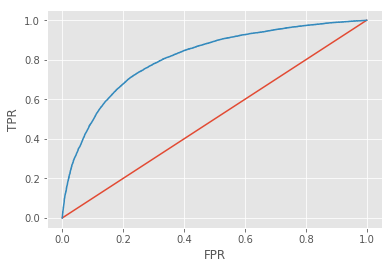

In [34]:
final = LogisticRegressionCV(Cs=[0.3],cv=5)
final.fit(X_scaled, np.ravel(y))
y_score = final.predict_proba(X_scaled)[:,1]

fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()

plt.plot([0,1],[0,1]) # this is our baseline
plt.plot(fpr, tpr) # this is our ROC curve
plt.xlabel('FPR')
plt.ylabel('TPR')

print('AUC: ', roc_auc)

In [35]:
# Create list of model coefficients.
final_coef=[]
for e in final.coef_:
    for i in e:
        final_coef.append(i)

labeled_coef=list(zip(X.columns,final_coef))

for e in labeled_coef:
    print (e)

('VE_TOTAL', -0.038076847484847264)
('PVH_INVL', 0.1116318821079728)
('PERNOTMVIT', -0.8553274485522356)
('PERMVIT', -0.19441784333964954)
('SCH_BUS', -0.00581975263340401)
('FATALS', 0.08886215318290026)
('DAY_1', 0.011288218903499625)
('DAY_2', -0.00650896476981981)
('DAY_3', 0.004401817906108878)
('DAY_4', 0.012975656773311329)
('DAY_5', 0.008193115992691864)
('DAY_6', -0.030969155170715034)
('DAY_7', 0.019140673989052122)
('DAY_8', -0.008267127691744395)
('DAY_9', -0.04076279181669738)
('DAY_10', -0.025802614183878123)
('DAY_11', -0.019046515836942345)
('DAY_12', 0.005568294846334732)
('DAY_13', 0.011462685728387916)
('DAY_14', 0.013616686863418673)
('DAY_15', 0.015004164708379017)
('DAY_16', -0.00012037251432198834)
('DAY_17', -0.025059326411076548)
('DAY_18', -0.02762548246849629)
('DAY_19', 0.0013991230879614532)
('DAY_20', 0.006236393394918116)
('DAY_21', 0.008776584136755906)
('DAY_22', -0.015530797426862177)
('DAY_23', -0.013313741615009315)
('DAY_24', 0.006298090014190202)
(

In [41]:
# Sort the list of model coefficients.
labeled_coef_sorted=sorted(labeled_coef, key=lambda e: e[1])

In [42]:
labeled_coef_sorted

[('PERNOTMVIT', -0.8553274485522356),
 ('HOUR_10', -0.29175133347162124),
 ('HOUR_12', -0.28059806915854135),
 ('HOUR_9', -0.2745011866615273),
 ('HOUR_8', -0.2706369315860296),
 ('HOUR_14', -0.25475614861229756),
 ('HOUR_11', -0.2536397772966214),
 ('HOUR_13', -0.24641767157163927),
 ('HOUR_15', -0.21295440859136608),
 ('FUNC_SYS_1', -0.20255651471053526),
 ('PERMVIT', -0.19441784333964954),
 ('HOUR_7', -0.18783941016057573),
 ('DRIMPAIR_1', -0.1854051540283498),
 ('HOUR_16', -0.1619849548368788),
 ('MDRMANAV_5', -0.15802725068196188),
 ('HOUR_6', -0.14199130044288077),
 ('DRIMPAIR_2', -0.12448600936710683),
 ('MDAREAS_15', -0.11386062560604002),
 ('DAY_WEEK_2', -0.11245603439110542),
 ('STATE_28', -0.11032217974859088),
 ('FUNC_SYS_3', -0.10763027762926251),
 ('STATE_18', -0.10334361995729702),
 ('MDRDSTRD_12', -0.10040148326532913),
 ('MDRDSTRD_0', -0.0965666072881326),
 ('MDRDSTRD_18', -0.09493009520594581),
 ('DAY_WEEK_4', -0.09369129185972695),
 ('HOUR_17', -0.08645704862127637),

In [36]:
lm_confusion = confusion_matrix(y, final.predict(X_scaled))
print (lm_confusion)

[[21315  1989]
 [ 4714  3903]]


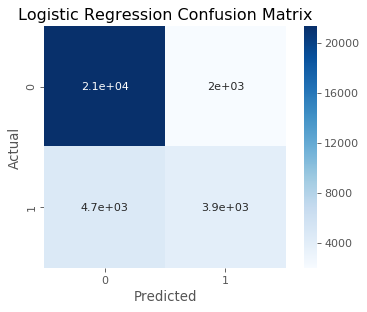

In [37]:
plt.figure(dpi=80)
sns.heatmap(lm_confusion, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix');

In [38]:
def make_confusion_matrix(model, threshold):
    y_predict = (model.predict_proba(X_scaled)[:, 1] >= threshold)
    model_confusion = confusion_matrix(y, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(model_confusion/len(X_scaled), cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['No Drunk Driving','Drunk Driving'],
           yticklabels=['No Drunk Driving','Drunk Driving']);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(horizontalalignment='center')
    plt.yticks(verticalalignment='center')
    plt.title("Drunk Driving Predictions (prob > {}%)".format(int(threshold*100)))

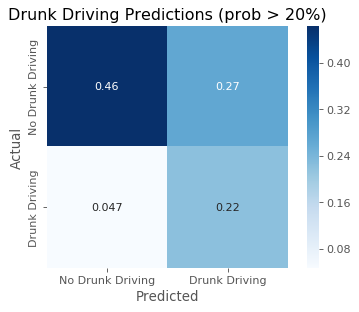

In [39]:
make_confusion_matrix(final, 0.2) # Examine confusion matrix with probability threshold of 20%.

In [43]:
final.predict_proba(X_scaled)

array([[0.34935563, 0.65064437],
       [0.67156873, 0.32843127],
       [0.41922449, 0.58077551],
       ...,
       [0.81350964, 0.18649036],
       [0.529019  , 0.470981  ],
       [0.58204794, 0.41795206]])

In [44]:
final.predict(X_scaled)

array([1, 0, 1, ..., 0, 0, 0])

In [77]:
final.predict_proba(X_scaled).shape

(31921, 2)

In [98]:
# Create list of model probabilities for each row in dataset.
y_pred_proba=[]
for e in final.predict_proba(X_scaled):
    y_pred_proba.append(e[1])

In [99]:
y_pred_proba

[0.6506443693361286,
 0.328431268036351,
 0.5807755104132374,
 0.6904758229016575,
 0.1105993605517487,
 0.09700266551935459,
 0.1665056408575369,
 0.2476856995959368,
 0.07864875825712044,
 0.22496503250754973,
 0.3620024497527218,
 0.033641211133899895,
 0.1989369830473607,
 0.2663455269927389,
 0.17777366950076026,
 0.16103389101627955,
 0.03876328076535008,
 0.3603274634081901,
 0.6802426031439549,
 0.17161448616734815,
 0.05375068381657458,
 0.05639931485650988,
 0.35422527911331686,
 0.13230882186415432,
 0.6377158656009261,
 0.09821875288153895,
 0.12173691508345923,
 0.6849863849538913,
 0.2523991429139704,
 0.3187050129055869,
 0.013781315057169072,
 0.48138536654116176,
 0.6149033222187746,
 0.051056164542630136,
 0.05518890903656386,
 0.062284123338669097,
 0.12085700184808079,
 0.2765020696153789,
 0.5650208675549844,
 0.028045669603399333,
 0.5073430802290176,
 0.09588094918011972,
 0.6065501675630537,
 0.5537987818570197,
 0.10723318451915527,
 0.6679487671409027,
 0.6058

In [97]:
df_proba=master # Create new data frame for appending model probabilities.

In [100]:
y_pred_proba=np.asarray(y_pred_proba)

In [101]:
y_pred_proba

array([0.65064437, 0.32843127, 0.58077551, ..., 0.18649036, 0.470981  ,
       0.41795206])

In [102]:
df_proba['y_pred_proba']=y_pred_proba # Append model probabilities.

In [103]:
df_proba

,ST_CASE,VE_TOTAL,PVH_INVL,PERNOTMVIT,PERMVIT,SCH_BUS,FATALS,DRUNK_DR,DAY_1,DAY_2,...,MFACTOR_15,MFACTOR_16,MFACTOR_17,MDRMANAV_0,MDRMANAV_1,MDRMANAV_2,MDRMANAV_3,MDRMANAV_4,MDRMANAV_5,y_pred_proba
0,10001,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0.650644
1,10002,1,0,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0.328431
2,10003,1,0,0,2,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0.580776
3,10004,1,0,0,1,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0.690476
4,10005,2,0,0,2,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0.110599
5,10006,1,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.097003
6,10007,1,0,0,2,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0.166506
7,10008,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.247686
8,10009,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.078649
9,10010,2,0,0,2,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0.224965


In [104]:
os.getcwd()

'/Users/skyler/Downloads/2015-traffic-fatalities'

In [105]:
df_proba.to_csv('df_proba.csv') # Send data frame with model probabilities to csv for importing into Tableau.